#Mount Google Drive and Navigate to Dataset folder


In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd '/content/drive/MyDrive/SURGICAL_MASKS_DATASET/'

/content/drive/MyDrive/SURGICAL_MASKS_DATASET


#Setup GPU, Fetching data, etc.

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from skimage import io
import pandas as pd
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [5]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f'DEVICE: {device}')

DEVICE: cuda


#Hyperparameters

In [6]:
IMAGE_RESIZE_DIM = 480
IMAGE_CROP_SIZE = 227
BATCH_SIZE = 4

#Loading Data

In [7]:
#Function to create file names and label them
def CreateCSVFromDataframe(dataset_type):
  #Create Dataframe with column names
  train_df = pd.DataFrame(columns=['image_name','label'])

  # Store listed file names under `image_name` column and label them as 1
  train_df["image_name"] = os.listdir(f'./{dataset_type}/Mask/')

  # Add subfolder location to file name for future ease of fetching
  for index, value in enumerate(train_df['image_name']):
    train_df.iloc[index][0] = f'/Mask/{train_df.iloc[index][0]}'

  no_mask_index = len(train_df)
  train_df['label'][0:no_mask_index] = 1

  # Store file names from Non Mask folder under `image_name` and label them as 0
  train_df = train_df.append(pd.DataFrame(os.listdir(f'{dataset_type}/Non Mask/'), columns=['image_name']))
  train_df['label'][no_mask_index:len(train_df)] = 0
  for index in range(no_mask_index, len(train_df)):
    train_df.iloc[index][0] = f'/Non Mask/{train_df.iloc[index][0]}'
  return train_df

In [8]:
#Load data from drive
train_df = CreateCSVFromDataframe(dataset_type = 'Train')

In [9]:
# Store dataframe to csv file
train_df.to_csv(r'./Train/train_csv.csv', index=False, header=True)

#Creating custom Dataset and Defining dataset variable

In [10]:
#Custom Torch Dataset to dealing with data
class MaskNoMaskDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.file_names = pd.read_csv(f'{root_dir}/{csv_file}')
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.file_names)
  
  def __getitem__(self, index):
    img_path = f'{self.root_dir}/{self.file_names.iloc[index, 0]}'
    label = torch.tensor(int(self.file_names.iloc[index, 1]))
    image = Image.open(img_path)

    if self.transform:
      image = self.transform(image)
    else:
      image = torch.tensor(image)
    return (image, label)

In [11]:
# Load Data
train_dataset = MaskNoMaskDataset(csv_file = 'train_csv.csv', root_dir ='Train', transform = transforms.Compose([
    transforms.Resize(IMAGE_RESIZE_DIM),
    transforms.CenterCrop((IMAGE_CROP_SIZE, IMAGE_CROP_SIZE)),
    transforms.ToTensor(),
]))

#Initialize DataLoader and add dataset into it

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

#Define CNN Model

In [13]:
class NNModel(nn.Module):
  def __init__(self):
      super(NNModel, self).__init__()

      self.conv1 = nn.Conv2d(3, 32, 5, 1)
      self.maxpool = nn.MaxPool2d(3, 2)
      self.conv2 = nn.Conv2d(32, 64, 3, 1)
      self.maxpool = nn.MaxPool2d(3, 2)     # Redefined just for neural network structure understanding
      self.dropout2 = nn.Dropout2d(0.5)
      self.conv3 = nn.Conv2d(64, 128, 3, 1)
      self.conv4 = nn.Conv2d(128, 32, 3, 1)

      self.fc1 = nn.Linear(32 * 50 * 50, 128)
      self.fc2 = nn.Linear(128, 2)
      self.relu = nn.ReLU()

  def forward(self, x):
    x = self.maxpool(self.relu(self.conv1(x)))
    x = self.maxpool(self.relu(self.conv2(x)))
    x = self.relu(self.conv3(x))
    x = self.relu(self.conv4(x))

    x = torch.flatten(x, 1)
    x = self.dropout2(x)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

In [14]:
model = NNModel()

In [15]:
model = model.to(device)

#Define Loss Criterion and Optimizer

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.09)

In [22]:
def train_model(epoch = 5):
  total_accuracy = []
  total_loss = []
  for i in range(epoch):
    data_length = 0
    estimated_loss = 0
    accuracy = 0
    for index, data in enumerate(train_dataloader,0):
      image, label = data
      image = image.to(device)
      label = label.to(device)
      output = model(image)
      optimizer.zero_grad()
      loss = F.nll_loss(output, label.long())
      prediction = torch.argmax(output, dim=1)

      loss.backward()
      optimizer.step()
      estimated_loss +=loss.item()
      accuracy += (prediction == label).int().sum().item()
      data_length += label.shape[0]
      
      if(index%20 == 0): 
          print(f'Total Loss:{estimated_loss/data_length}')
          print(f'Total Accuracy:{accuracy/data_length}')
    total_accuracy.append(int(accuracy)/data_length)
    total_loss.append(int(estimated_loss/data_length))
  return total_accuracy, total_loss 

In [18]:
accuracy, loss = train_model()

Total Loss:0.17660154402256012
Total Accuracy:0.0
Total Loss:0.17362022896607718
Total Accuracy:0.4523809523809524
Total Loss:0.17371858620062108
Total Accuracy:0.45121951219512196
Total Loss:0.17362333687602496
Total Accuracy:0.47950819672131145
Total Loss:0.1736558504678585
Total Accuracy:0.48148148148148145
Total Loss:0.17364023802894177
Total Accuracy:0.48267326732673266
Total Loss:0.17342455328003434
Total Accuracy:0.49586776859504134
Total Loss:0.1734618992670208
Total Accuracy:0.49822695035460995
Total Loss:0.17339653933640592
Total Accuracy:0.5031055900621118


In [ ]:
torch.save(model.state_dict(), './trained_model.pt')

#Validation

In [18]:
# Fetch data into variables from drive
val_data = CreateCSVFromDataframe(dataset_type= 'Validation')

In [19]:
# Store created CSV file into Validation folder in Drive
val_data.to_csv('./Validation/validation_data.csv', index= False, header= True)

##Create model instance and load state_dicts from gdrive


In [20]:
# Load model state_dicts from gdrive into model
model = NNModel()
model.load_state_dict(torch.load('./trained_model.pt'))

model = model.to(device)

##Load validation dataset and dataloader

In [21]:
val_dataset = MaskNoMaskDataset('validation_data.csv', root_dir= 'Validation', transform= transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(227),
    transforms.ToTensor(),
]))

In [22]:
val_dataloader = torch.utils.data.DataLoader(val_dataset, BATCH_SIZE, shuffle= True, num_workers= 2)

In [40]:
# Validate Data
def validation():
  model.eval()
  loss = 0
  length = 0
  accuracy = 0
  total_loss = []
  total_accuracy = []
  images = []
  labels = []
  with torch.no_grad():
    for index, data in enumerate(val_dataloader, 0):
      image, label = data
      image, label = (image.to(device), label.to(device))
      output = model(image)
      loss = F.nll_loss(output, (label).long())
      prediction = output.argmax(dim=1)
      images.append(image)
      labels.append(prediction)

      accuracy += (prediction == label).float().sum()
      # print(f'accuracy count: {accuracy/output.shape[0]}')
      
      loss += loss.item()
      length += label.shape[0]

      if(length%8 == 0):
        total_loss.append(float(loss/length))
        total_accuracy.append(accuracy.cpu().item()/length)
        print(f'Total Loss:{(float(loss/length)*100):.2f}%')
        print(f'Total Accuracy:{((accuracy/length)*100):.2f}%')
  return (images, labels, total_loss, total_accuracy)

In [41]:
images, results, loss, accuracy = validation()

Total Loss:10.44%
Total Accuracy:62.50%
Total Loss:4.72%
Total Accuracy:81.25%
Total Loss:1.38%
Total Accuracy:87.50%
Total Loss:3.24%
Total Accuracy:90.62%
Total Loss:1.53%
Total Accuracy:92.50%
Total Loss:2.71%
Total Accuracy:87.50%
Total Loss:1.24%
Total Accuracy:87.50%
Total Loss:0.78%
Total Accuracy:87.50%
Total Loss:1.61%
Total Accuracy:86.11%
Total Loss:2.18%
Total Accuracy:86.25%
Total Loss:0.54%
Total Accuracy:86.36%
Total Loss:0.31%
Total Accuracy:87.50%
Total Loss:0.84%
Total Accuracy:86.54%
Total Loss:0.44%
Total Accuracy:86.61%
Total Loss:2.48%
Total Accuracy:85.83%
Total Loss:0.41%
Total Accuracy:85.94%
Total Loss:0.54%
Total Accuracy:86.76%
Total Loss:0.36%
Total Accuracy:86.81%
Total Loss:0.64%
Total Accuracy:86.84%
Total Loss:0.32%
Total Accuracy:86.88%
Total Loss:0.44%
Total Accuracy:87.50%
Total Loss:0.58%
Total Accuracy:86.93%
Total Loss:0.15%
Total Accuracy:86.96%
Total Loss:0.35%
Total Accuracy:86.98%
Total Loss:0.33%
Total Accuracy:87.00%
Total Loss:0.24%
Total A

In [32]:
images = np.array(images)
results = np.array(results)

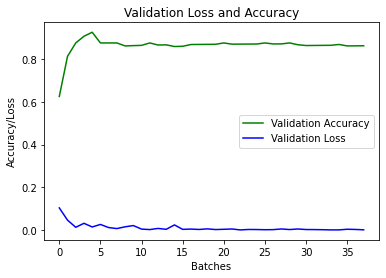

In [54]:
epochs = range(0, int(len(accuracy)))

plt.plot(epochs, accuracy, 'g', label='Validation Accuracy')
plt.plot(epochs, loss, 'b', label="Validation Loss")
plt.title("Validation Loss and Accuracy")
plt.xlabel('Batches')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
def display_image_grid(dataset, results, grid_size=4):
  fig, axes = plt.subplots(grid_size, 4, figsize=(8,8))
  row_index = 0
  for i in range(0,grid_size):
    for j in range(0,4):
      axes[i][j].set(ylabel=results[i][j].item())
      axes[i][j].imshow(dataset[i][j].cpu().permute(1,2,0))
      axes[i][j].legend()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


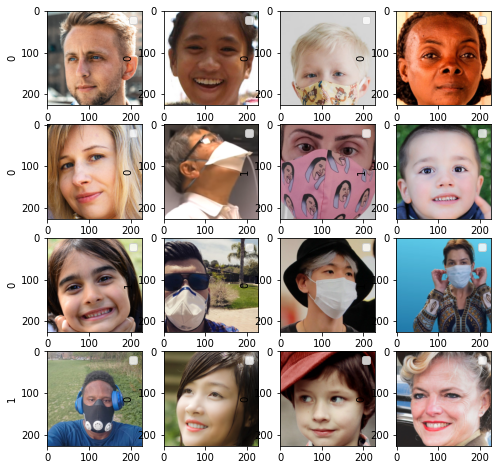

In [ ]:
display_image_grid(images, results, grid_size= 4)